# 🦸♀️ Avengers RL — Small Specialists, United They Stand

**The Final Showdown: Can specialized LoRA-trained models outperform a 20B parameter giant?**

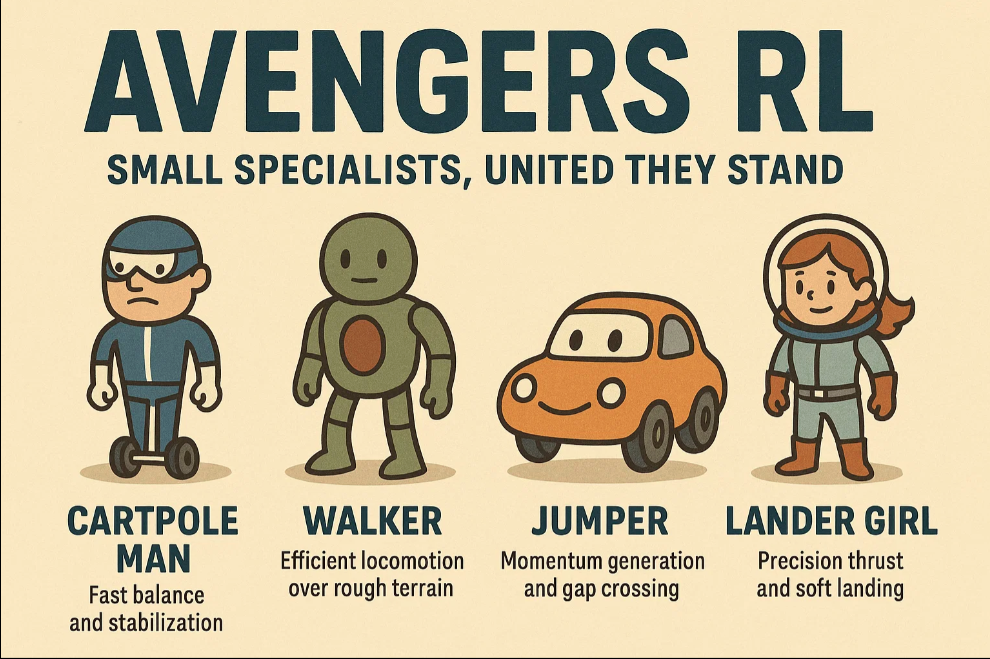

## Introduction

In this notebook, we pit the Avengers team of specialized LoRA adapters against Thanos - a massive 20B parameter model to determine:

**Can specialization + coordination out-perform brute size?**

### The Contestants
- 🦸 **Avengers Team**: 4 LoRA adapters, each specialized for one environment
  - Captain America (CartPole)
  - Iron Man (MountainCarContinuous) 
  - Thor (LunarLanderContinuous)
  - Black Widow (BipedalWalker-v3)
- 🟣 **Thanos**: `unsloth/gpt-oss-20b` - a 20B parameter model with no task-specific training

### The Challenge
- Each contestant must generate Python strategies for each environment
- Strategies are evaluated across multiple runs (up to 10K steps per episode)
- Success metrics: reward, completion rate, efficiency

Let's see if the lesson from comic books holds: **United we stand > Alone you fall**

## 📋 Setup & Imports

First, let's install the required dependencies and set up our environment.

In [1]:
# Install required packages (uncomment if needed)
# !pip install transformers torch peft unsloth accelerate openenv matplotlib seaborn plotly

import os
import sys
import time
import json
import ast
import re
import numpy as np
import pandas as pd
from typing import Dict, List, Tuple, Optional
from concurrent.futures import ThreadPoolExecutor
from textwrap import dedent

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ML/AI libraries
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, TextStreamer
from peft import PeftModel
from unsloth import FastLanguageModel
from unsloth import create_locked_down_function
from unsloth import check_python_modules

# OpenEnv for environments
from envs.sequential_environment import SequentialEnvironment, SequentialAction
from envs.sequential_environment.client import SequentialEnv

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("🎯 All imports successful!")
print(f"🔧 PyTorch version: {torch.__version__}")
print(f"🖥️ CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"🖥️ GPU: {torch.cuda.get_device_name(0)}")

/workspace/unsloth_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_119344/2792008468.py:27: UserWarning: WARNING: Unsloth should be imported before transformers, peft to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastLanguageModel


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


INFO:envs.cartpole_environment.server.cartpole_environment: Creating CartPole-v1 environment with render_mode=None, max_steps=100000, seed=None
INFO:envs.cartpole_environment.server.cartpole_environment: CartpoleEnvironment initialized successfully
INFO:envs.sequential_environment.server.sequential_environment: Creating sub-environments with seed=None
INFO:envs.cartpole_environment.server.cartpole_environment: Creating CartPole-v1 environment with render_mode=None, max_steps=10000, seed=None
INFO:envs.cartpole_environment.server.cartpole_environment: CartpoleEnvironment initialized successfully
INFO:envs.mountaincarcontinuous_environment.server.mountaincarcontinuous_environment: Creating MountainCarContinuous-v0 environment with render_mode=None, max_steps=1000, seed=None
INFO:envs.mountaincarcontinuous_environment.server.mountaincarcontinuous_environment: MountainCarContinuousEnvironment initialized successfully
INFO:envs.lunarlander_environment.server.lunarlander_environment: Creatin

🎯 All imports successful!
🔧 PyTorch version: 2.8.0+rocm6.4
🖥️ CUDA available: True
🖥️ GPU: AMD Radeon Graphics


In [2]:

# Initialize OpenEnv Sequential Environment Client
max_steps = 10000
seed = 42
max_seq_length = 2048


client = SequentialEnv(
    base_url="http://localhost:8060"
)
# If Connection fails, Please remember to start the OpenEnv Sequential Environment for Endgame by running bash OpenEnv/scripts/start_sequential_environment.sh 
# It is running on a tmux window for examination purpose, if it goes down please bring it back up.
# Running server subprocess in Jupyter has many issues, hence running it in a tmux shell

print("🛰️ Connected to OpenEnv Sequential Environment Server containing CartPole, BiPedalWalker, MountainCar, LunarLanderContinuous")
print(client.reset())
#print(f"🎮 Available Environments: {available_environments}")

🛰️ Connected to OpenEnv Sequential Environment Server containing CartPole, BiPedalWalker, MountainCar, LunarLanderContinuous
StepResult(observation=SequentialObservation(done=False, reward=0.0, metadata={}, state=[1.0, 0.0, 0.0, 0.0, -0.028146730735898018, -0.02394154481589794, -0.04505480080842972, 0.0038599211256951094], phase='cartpole', sub_observation=[-0.028146730735898018, -0.02394154481589794, -0.04505480080842972, 0.0038599211256951094], episode_length=0, total_reward=0.0), reward=0.0, done=False)


## 🤖 Model Loading Section

### The Avengers: Specialized LoRA Models

Each Avenger is a LoRA adapter trained on a specific environment.

In [3]:
# Configuration for Avengers models
AVENGERS_CONFIG = {
    'cartpole': {
        'name': 'Captain America (CartPole)',
        'adapter_path': '/shared-docker/adapters/cartpole-lora-grpo_trained',
        'base_model': 'unsloth/Llama-3.2-3B-Instruct'  # Assuming base model, update if different
    },
    'mountaincarcontinuous': {
        'name': 'Iron Man (MountainCarContinuous)',
        'adapter_path': '/shared-docker//adapters/mountaincart-lora-grpo_trained',
        'base_model': 'unsloth/Llama-3.2-3B-Instruct'  # Assuming base model, update if different
    },
    'lunarlandercontinuous': {
        'name': 'Thor (LunarLanderContinuous)',
        'adapter_path': '/shared-docker//adapters/lunarlander-lora-grpo_trained',
        'base_model': 'unsloth/Llama-3.2-3B-Instruct'  # Assuming base model, update if different
    },
    'bipedalwalker': {
        'name': 'Black Widow (Bipedal Walker)',
        'adapter_path': '/shared-docker//adapters/bipedal-walker-grpo_trained',
        'base_model': 'unsloth/Llama-3.2-3B-Instruct'  # Assuming base model, update if different
    }
}

# Thanos configuration
THANOS_CONFIG = {
    'name': 'Thanos (20B Parameter Giant)',
    'model_name': 'unsloth/gpt-oss-20b',
    'max_seq_length': max_seq_length  # Adjust as needed
}

print("⚙️ Model configurations loaded")

⚙️ Model configurations loaded


In [4]:
# Load Avengers models (LoRA adapters)
avengers_models = {}

# Load base model
model_base, tokenizer_base = FastLanguageModel.from_pretrained(
            model_name=AVENGERS_CONFIG['cartpole']['base_model'],
            load_in_4bit=False,
            max_seq_length=max_seq_length
        )

for env_name, config in AVENGERS_CONFIG.items():
    print(f"\n🏆 Loading {config['name']}...")
    
    try:

        
        # Load LoRA adapter
        model_avenger = PeftModel.from_pretrained(model_base, config['adapter_path'])
        
        # Enable faster inference
        FastLanguageModel.for_inference(model_avenger)
        
        avengers_models[env_name] = {
            'model': model_avenger,
            'tokenizer': tokenizer_base,
            'config': config
        }
        
        print(f"✅ {config['name']} loaded successfully")
        
    except Exception as e:
        print(f"❌ Failed to load {config['name']}: {str(e)}")
        
print(f"\n🦸 Avengers Team Ready: {len(avengers_models)} heroes loaded")

Unsloth: AMD currently is not stable with 4bit bitsandbytes. Disabling for now.
==((====))==  Unsloth 2025.10.9: Fast Llama patching. Transformers: 4.56.2.
   \\   /|    AMD Radeon Graphics. Num GPUs = 1. Max memory: 191.688 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+rocm6.4. ROCm Toolkit: 6.4.43482-0f2d60242. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards: 100% 2/2 [00:02<00:00,  1.22s/it]



🏆 Loading Captain America (CartPole)...
✅ Captain America (CartPole) loaded successfully

🏆 Loading Iron Man (MountainCarContinuous)...
✅ Iron Man (MountainCarContinuous) loaded successfully

🏆 Loading Thor (LunarLanderContinuous)...
✅ Thor (LunarLanderContinuous) loaded successfully

🏆 Loading Black Widow (Bipedal Walker)...
✅ Black Widow (Bipedal Walker) loaded successfully

🦸 Avengers Team Ready: 4 heroes loaded


In [5]:
# Load Thanos (20B model)
print(f"🟣 Loading {THANOS_CONFIG['name']}...")

try:
    thanos_model, thanos_tokenizer = FastLanguageModel.from_pretrained(
        model_name=THANOS_CONFIG['model_name'],
        load_in_4bit=True,
        max_seq_length=THANOS_CONFIG['max_seq_length']
    )
    
    # Enable faster inference
    FastLanguageModel.for_inference(thanos_model)
    
    print(f"✅ {THANOS_CONFIG['name']} loaded successfully")
    print(f"📏 Model parameters: ~{thanos_model.num_parameters():,}")
    
except Exception as e:
    print(f"❌ Failed to load {THANOS_CONFIG['name']}: {str(e)}")
    thanos_model = None
    thanos_tokenizer = None

print("\n⚔️ Battle preparations complete! Avengers vs Thanos")

🟣 Loading Thanos (20B Parameter Giant)...
Unsloth: AMD currently is not stable with 4bit bitsandbytes. Disabling for now.
Unsloth: AMD currently is not stable with 4bit bitsandbytes. Disabling for now.
==((====))==  Unsloth 2025.10.9: Fast Gpt_Oss patching. Transformers: 4.56.2.
   \\   /|    AMD Radeon Graphics. Num GPUs = 1. Max memory: 191.688 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+rocm6.4. ROCm Toolkit: 6.4.43482-0f2d60242. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: QLoRA and full finetuning all not selected. Switching to 16bit LoRA.


Loading checkpoint shards: 100% 3/3 [00:05<00:00,  1.81s/it]


✅ Thanos (20B Parameter Giant) loaded successfully
📏 Model parameters: ~20,914,757,184

⚔️ Battle preparations complete! Avengers vs Thanos


## 🎯 Strategy Generation System

Each model must generate Python functions that implement their strategies for each environment.
We provide structured prompts with environment details and action space requirements.

Avengers RL — Strategy Parser

WHY THIS EXISTS
---------------
In the Avengers RL setup, each "Avenger" (specialist agent) is configured with a natural-language
`prompt` that *also* embeds a concrete Python policy function. During experiment setup, we need to:

1) Extract the policy function definition for that Avenger (e.g., `def cartpole_strategy(state): ...`)
2) Compile it in a tightly restricted environment (via `create_locked_down_function`)
3) Hand the callable strategy back to the simulator/router

This module provides two tiny helpers for that minimal workflow:
- `_safe_compile`: hands raw source to the notebook/runtime’s locked-down compiler (assumed provided)
- `extract_function`: finds the first `def ...strategy...` function inside the first triple-backtick block

SCOPE & ASSUMPTIONS
-------------------
- We assume the *first* fenced code block ```...``` in the text contains the function.
- We assume a Python function name containing the substring "strategy" (e.g., `*_strategy*`).
- We strip an optional "python" language tag from the start of the code block.
- We return the function **from the `def` line onward**; we do not parse/validate indentation or body.
- This is intentionally *not* robust—lightweight by design for fast iteration in notebooks.


In [6]:
def extract_python_function(text: str):
    """
    Extract the first Python function whose `def` line contains the substring 'strategy'
    from the first fenced code block in the given text.

    Parameters
    ----------
    text : str
        A string that includes exactly one strategy function wrapped in triple backticks:
        ```
        python
        def some_env_strategy(state):
            ...
        ```
        The 'python' language tag is optional.

    Returns
    -------
    str | None
        The function source beginning at the 'def' line, or None if nothing matched.

    Design Choices
    --------------
    - Minimal scanning (no regex, no AST) to keep it simple and fast in notebooks.
    - Intended for well-formed prompts that we control in this project.
    """
    # Assume the function is between the first pair of triple backticks
    if text.count("```") >= 2:
        first = text.find("```") + 3
        second = text.find("```", first)
        fx = text[first:second].strip()

        # Strip optional language tag like "python\n"
        if fx.startswith("python\n"):
            fx = fx[len("python\n"):]

        # Find the first 'def ...strategy...' line and return from there (inclusive)
        i = 0
        while True:
            idx = fx.find("def", i)
            if idx == -1:
                break
            line_end = fx.find("\n", idx)
            line = fx[idx:] if line_end == -1 else fx[idx:line_end]
            if "strategy" in line:
                return fx[idx:].rstrip()
            i = idx + 3
    return None


def _safe_compile(func_src: str):
    """
    Compile a strategy function in a restricted environment.

    Parameters
    ----------
    func_src : str
        The full source code of a single Python function definition starting at 'def ...'.

    Returns
    -------
    callable
        A callable function object constructed by the notebook/runtime's sandboxed compiler.

    Notes
    -----
    - We rely on a global `create_locked_down_function` symbol provided by the notebook runtime.
      It should evaluate/compile the given source with limited builtins and no file/network access.
    - This indirection keeps our code agnostic of the underlying sandbox implementation.
    """
    # Use the notebook's 'create_locked_down_function' if present
    return create_locked_down_function(func_src)


In [7]:
ENV_CONFIGS = {
    'cartpole': {
            'description': 'CartPole-v1: Balance a pole on a cart. The cart can move left/right, pole must stay upright.',
            'observation_space': 'Box(4): [cart_position, cart_velocity, pole_angle, pole_angular_velocity]',
            'action_space': 'Discrete(2): [0=left, 1=right]',
            'reward_structure': 'Reward +1 for each timestep pole remains upright, episode ends when pole falls (>15°) or 500 steps',
            'difficulty': 'Easy - requires basic balance control',
            'prompt': dedent("""You are an expert CartPole player and a precise Python code generator.
                
                Context / How this will be used
                - Your function will be called every environment step to control the entire episode of CartPole-v1 (OpenAI Gym/Gymnasium style).
                - The simulator updates at ~0.02 s per step (≈50 Hz).
                - The episode ends early if the pole falls or the cart goes out of bounds; otherwise it caps at the env’s max length.
                  - Termination (approx.): |angle| > ~0.209 rad (≈12°) or |x| > 2.4 m.
                  - Reward is +1 per step; the goal is to survive as long as possible (ideally to the cap).
                
                Your objective: keep the pole upright and the cart within bounds for the longest possible duration.
                
                What you must write
                - A single Python function with this exact signature (no extras):
                    def cartpole_strategy(state):
                - Input state is a list of 4 floats: [x, dx, angle, dangle]
                  - x = cart position (m)
                  - dx = cart velocity (m/s)
                  - angle = pole angle (rad, 0 is upright; + leans right)
                  - dangle = angular velocity (rad/s)
                - Output: return an int action — 0 (push left) or 1 (push right).
                
                Design guidance for long-horizon stability
                - Prioritize angle correction, then angular velocity damping, and only then center the cart (x, dx) to avoid boundary terminations.
                - Use a simple deterministic control law (e.g., a weighted linear rule with a small dead-zone/hysteresis to avoid flapping on noise).
                - Keep it short and stateless (no memory): e.g., one or two thresholds or a sign of a weighted sum is fine.
                - Avoid overreacting to tiny oscillations; prefer small margins rather than exact limit chasing.
                - No stochasticity; identical inputs must produce identical outputs.
                
                Hard constraints
                - Do not import, print, read/write files, use globals, randomness, or I/O.
                - The output must be exactly one fenced code block in Python, with nothing before or after.
                  - The first line inside the block must be: def cartpole_strategy(state):
                  - The last line of your entire response must be the closing backticks to clearly end the program. No trailing commentary.
                
                Output format reminder (dummy example — do NOT copy this logic):
                ```
                def cartpole_strategy(state):
                    x, dx, ang, dang = state
                    # return 0 or 1 using a short, deterministic rule
                    return 1 if (0.9*ang + 0.4*dang + 0.05*x + 0.02*dx) > 0 else 0 
                ```
                All helper functions should be inside def cartpole_strategy. Only output the short function `strategy`.
                """)
                    },
                
    'mountaincarcontinuous': {
                    'description': 'MountainCarContinuous-v0: Drive a car up a hill using momentum.',
                    'observation_space': 'Box(2): [car_position (-1.2 to 0.6), car_velocity (-0.07 to 0.07)]',
                    'action_space': 'Box(1): continuous force (-1.0 to 1.0)',
                    'reward_structure': 'Reward = 100 * (position - (-0.5))^2 + 0.1 * velocity^2, goal position = 0.45',
                    'difficulty': 'Medium - requires learning to build momentum in reverse',
                    'prompt': dedent("""You are an expert MountainCarContinuous player and a precise Python code generator.
            
            Context / How this will be used
            - Your function will be called every environment step to control the entire episode of MountainCarContinuous-v0 (OpenAI Gym/Gymnasium style, continuous actions).
            - The episode ends when the car reaches the goal (typically x ≥ 0.45–0.5) or when the environment hits its max step limit.
            - Reward shaping encourages reaching the goal quickly while using as little engine force as possible (penalizes large |action|).
            
            Your objective: reach the goal position as fast as possible by smartly building and exploiting momentum on the hills, while avoiding wasteful throttle.
            
            What you must write
            - A single Python function with this exact signature (no extras):
                def mountaincar_strategy(state):
            - Input `state` is a list of 2 floats: [x, v]
              - x = car position (range about [-1.2, 0.6])
              - v = car velocity (range about [-0.07, 0.07])
            - Output: return a **float** action in **[-1.0, 1.0]**
              - negative = throttle left, positive = throttle right, zero ≈ coasting.
              - The caller will pass this scalar to the env (wrapping into a length-1 array if needed).
            
            Design guidance for long-horizon control
            - MountainCarContinuous requires **momentum pumping**: generally apply force in the direction of current velocity to amplify swings, then **time the reversal** to crest the right hill.
            - Prefer a **short, deterministic** control law (e.g., a weighted linear rule with saturating clamp to [-1, 1]).
            - Add a **deadband/hysteresis** around v ≈ 0 to avoid rapid action sign flips; coasting (≈0) can be beneficial when switching directions.
            - Useful heuristics:
              - If v > +ε, bias action right; if v < -ε, bias action left.
              - When far on the left (x < -0.5), allow larger left pushes to harvest momentum.
              - Near the final ascent on the right (x > -0.2), bias action right and reduce needless oscillation.
              - Optionally damp action magnitude by |v| to avoid over-throttling at high speeds.
            
            Hard constraints
            - Do not import, print, read/write files, use globals, randomness, or any I/O.
            - Keep the code short and stateless; identical inputs must produce identical outputs.
            - The output must be exactly one fenced code block in Python, with nothing before or after.
              - The first line inside the block must be: def mountaincar_strategy(state):
              - The last line of your entire response must be the closing backticks to clearly end the program. No trailing commentary.
            
            Output format reminder (dummy example — do NOT copy this logic):
            ```
            def mountaincar_strategy(state):
                x, v = state
                return 1 * x * v # dummy example
            ```
            All helper functions should be inside def mountaincar_strategy. Only output the short function `strategy`."""
                                    )
    },
    'lunarlandercontinuous': {
        'description': 'BipedalWalker-v3: Control a 2-legged robot to walk across uneven terrain without falling.',
        'observation_space': 'Box(8): position, velocity, angle, angular velocity, leg contact sensors',
        'action_space': 'Box(2): [main_engine_thrust (0-1), lateral_engine_force (-1 to 1)]',
        'reward_structure': 'Complex: landing, fuel efficiency, crash penalties, movement rewards',
        'difficulty': 'Hard - multi-dimensional continuous control',
        'prompt': dedent("""
        You are an expert LunarLander (continuous control) pilot and a precise Python code generator.

        Context / How this will be used
        - Your function will be called every environment step to control the entire episode of LunarLanderContinuous-v2 (OpenAI Gym/Gymnasium, Box2D).
        - The simulator runs at ~50 Hz. The episode ends when the lander is safely on the pad, crashes, flies off-screen, or hits the environment step cap.
        - The reward is shaped for soft, centered landings: proximity to the pad and zeroing velocity/tilt are good; fuel use and large forces are penalized; leg contacts yield bonuses; crashing yields large negatives.
        
        Your objective: achieve a safe, fuel-efficient landing near the center pad by minimizing horizontal/vertical speeds and tilt while avoiding hard thrusting.
        
        What you must write
        - A single Python function with this exact signature (no extras):
            def lunarlander_strategy(state):
        - Input `state` is a list of 8 values: [x, y, vx, vy, theta, vtheta, left_contact, right_contact]
          - x, y       = position relative to pad center (0,0)
          - vx, vy     = horizontal and vertical velocities
          - theta      = lander angle (radians; 0 is upright; positive leans right)
          - vtheta     = angular velocity
          - left_contact, right_contact = leg contact flags (0.0 or 1.0)
        - Output: return a length-2 sequence of floats **[main, lateral]**, each in **[-1.0, 1.0]**
          - `main`   = main engine command (upward thrust). Negative values are treated as “off”; positive values increase thrust.
          - `lateral`= side thruster command (negative pushes left, positive pushes right).
        
        Design guidance for long-horizon control
        - Prioritize **vertical stabilization** (reduce `vy`) and **upright attitude** (`theta≈0`, `vtheta≈0`), then **center horizontally** (`x≈0`, `vx≈0`).
        - Use **smooth, deterministic** control laws (e.g., weighted linear feedback with deadbands) and **clamp** outputs to [-1, 1].
        - Add small **dead-zones/hysteresis** around zero for `vx`, `vy`, and `theta` to avoid jitter and fuel waste.
        - Useful heuristics:
          - Main thrust should counteract downward speed: increase with positive descent rate (`vy < 0`) and with tilt error magnitude.
          - Lateral thruster should reduce horizontal error and velocity and help re-center the pad under the craft.
          - Reduce thrust when either leg has contact and vertical speed is small to prevent bouncing.
          - Cap commands gently to avoid saturating engines; prefer incremental adjustments as you approach touchdown.
        
        Hard constraints
        - Do not import, print, read/write files, use globals, randomness, or any I/O.
        - Keep the code short and stateless; identical inputs must produce identical outputs.
        - The output must be exactly one fenced code block in Python, with nothing before or after.
          - The first line inside the block must be: def lunarlander_strategy(state):
          - The last line of your entire response must be the closing backticks to clearly end the program. No trailing commentary.
        
        Output format reminder (dummy example — do NOT copy this logic):
        
        ```
        def lunarlander_strategy(state):
            x, y, vx, vy, th, vth, lc, rc = state
            m = x
            lat = y
            return [m, lat] # example 
        ```
        All helper functions should be inside def lunarlander_strategy. Only output the short function `strategy`.
            """.strip()
                        )
                },
    'bipedalwalker': {
                'description': 'BipedalWalker-v3: Control a 2-legged robot to walk across uneven terrain without falling.',
                'observation_space': (
                    'Box(24): [hull_angle, hull_angular_velocity, vel_x, vel_y, '
                    'joint angles & angular velocities for hips/knees (2 legs × 2 joints × 2), '
                    'leg contact flags (2), 10 LIDAR terrain range readings]'
                ),
                'action_space': 'Box(4): continuous joint torques in [-1, 1] for [left_hip, left_knee, right_hip, right_knee]',
                'reward_structure': (
                    'Shaped: positive for forward progress and stable posture; '
                    'penalties for excessive torque/energy and ground impacts; '
                    'large negative on falling. Episode ends on fall or time limit.'
                ),
                'difficulty': 'Hard – coordinated gait, balance, and energy management required',
                'prompt': dedent("""
            Create a new short **Bipedal Walker agent strategy** using only native Python code.
            You are given a 24-element list representing the current observation from the environment:
            `[hull_angle, hull_angular_velocity, horizontal_speed, vertical_speed, hip1_angle, hip1_speed, hip2_angle, hip2_speed, leg1_contact, hip3_angle, hip3_speed, hip4_angle, hip4_speed, leg2_contact, lidar_1, lidar_2, lidar_3, lidar_4, lidar_5, lidar_6, lidar_7, lidar_8, lidar_9, lidar_10]`
            
            Output one action as a list of 4 continuous values in the range `[-1.0, 1.0]`, corresponding to the motor speeds of the walker’s four joints:
            `[hip1, knee1, hip2, knee2]`.
            
            The goal is to move forward smoothly through uneven terrain without falling, keeping balance, maintaining momentum, and minimizing unnecessary torque.
            
            Follow these rules for better performance:
            
            1. **Balance First:** Keep the hull angle near zero and angular velocity small to stay upright.
            2. **Step Rhythmically:** Alternate leg movements to create a walking rhythm.
            3. **Gentle Force:** Avoid sudden, large torques — use small, smooth joint movements.
            4. **Forward Motion:** Encourage slight forward horizontal speed while avoiding high vertical speed.
            5. **Terrain Awareness:** Use lidar readings to detect upcoming slopes and adjust the step accordingly.
            6. **Recovery Logic:** If the hull tilts too much or a leg loses contact, adjust opposite leg torque to stabilize.
            
            Output your new short function in backticks using the format below:
            
            ```python
            def strategy(obs) -> list[float]:
                return [0, 0, 0, 0]  # Example
            ```
            
            All helper logic should be inside `def strategy`.
            Only output the short function `strategy`.
            """.strip()
                                )
        }

}

# Base prompt template
STRATEGY_PROMPT_TEMPLATE = """
{}
"""







# --- Example usage over ENV_CONFIGS ---
# In the Avengers RL config, each environment dictionary should include a 'prompt'
# that embeds a fenced code block with a `*strategy*` function.
for env in ENV_CONFIGS:
    print(f"Found new config for {env}")

    # Preview the beginning of the prompt for sanity
    print(ENV_CONFIGS[env]["prompt"][0:100])

    # Extract strategy source from the fenced code
    func_txt = extract_python_function(ENV_CONFIGS[env]["prompt"])
    print(func_txt)

    # Compile in a locked/sandboxed environment
    compiled_fn = _safe_compile(func_txt)
    print(compiled_fn)

    print("End of new config, function compiles OK\n")

Found new config for cartpole
You are an expert CartPole player and a precise Python code generator.

                Context / Ho
def cartpole_strategy(state):
                    x, dx, ang, dang = state
                    # return 0 or 1 using a short, deterministic rule
                    return 1 if (0.9*ang + 0.4*dang + 0.05*x + 0.02*dx) > 0 else 0
<function cartpole_strategy at 0x7913fc68b370>
End of new config, function compiles OK

Found new config for mountaincarcontinuous
You are an expert MountainCarContinuous player and a precise Python code generator.

            Con
def mountaincar_strategy(state):
                x, v = state
                return 1 * x * v # dummy example
<function mountaincar_strategy at 0x7913fc68aef0>
End of new config, function compiles OK

Found new config for lunarlandercontinuous
You are an expert LunarLander (continuous control) pilot and a precise Python code generator.

     
def lunarlander_strategy(state):
            x, y, vx, vy, th, 

In [8]:
from transformers import TextStreamer

In [9]:
import time
import torch
from typing import Tuple
from transformers import GenerationConfig

def generate_strategy(
    model,
    tokenizer,
    env_name: str,
    model_type: str = "specialist",   # "specialist" -> deterministic; "generalist" -> sampled
    max_new_tokens: int = 512,
    temperature: float = 0.7,
    top_p: float = 0.9,
    seed: int = 0,
) -> Tuple[str, float]:
    """
    Generate a strategy function for a given environment using a chat LLM.

    - Uses the tokenizer's chat template end-to-end.
    - Avoids double tokenization and brittle slicing.
    - Properly sets EOS/PAD and (de)terministic sampling based on model_type.
    """

    # 1) Build the prompt from your config
    cfg = ENV_CONFIGS[env_name]
    # Make sure STRATEGY_PROMPT_TEMPLATE has a single {} placeholder
    user_prompt = STRATEGY_PROMPT_TEMPLATE.format(cfg["prompt"])

    # 2) Render chat into model-ready text once (no double tokenization)
    chat = [{"role": "user", "content": user_prompt}]
    rendered = tokenizer.apply_chat_template(
        chat,
        tokenize=False,
        add_generation_prompt=True,   # adds the assistant prefix if template expects it
        reasoning_effort="low",       # ignored by most models; harmless if unsupported
    )

    # 3) Tokenize exactly once and move to model device
    device = getattr(model, "device", "cuda" if torch.cuda.is_available() else "cpu")
    inputs = tokenizer(rendered, return_tensors="pt").to(device)

    # 4) Reproducibility & eval guards
    model.eval()
    if seed is not None:
        torch.manual_seed(seed)
        if device == "cuda":
            torch.cuda.manualSeed(seed)

    # 5) Sampling mode
    do_sample = (model_type != "specialist")  # deterministic for "specialist"
    # temperature/top_p only matter if do_sample=True; set to safe defaults otherwise
    gen_cfg = GenerationConfig(
        max_new_tokens=max_new_tokens,
        do_sample=do_sample,
        temperature=temperature if do_sample else None,
        top_p=top_p if do_sample else None,
        # small helpers that often improve code quality
        repetition_penalty=1.05 if do_sample else 1.0,
    )

    # 6) EOS/PAD safety — important for chat models with special end tokens
    # Collect likely EOS tokens (model-dependent; harmless if missing)
    eos_ids = []
    for tok in ("eos_token_id",):
        tid = getattr(tokenizer, tok, None)
        if isinstance(tid, int):
            eos_ids.append(tid)
    # Some chat models define additional special ends like <|eot_id|>
    try:
        eot_id = tokenizer.convert_tokens_to_ids("<|eot_id|>")
        if isinstance(eot_id, int) and eot_id != tokenizer.unk_token_id:
            eos_ids.append(eot_id)
    except Exception:
        pass
    if eos_ids:
        gen_cfg.eos_token_id = eos_ids if len(eos_ids) > 1 else eos_ids[0]

    # Ensure pad_token_id exists to avoid warnings on some models
    if tokenizer.pad_token_id is None:
        tokenizer.pad_token = tokenizer.eos_token or tokenizer.unk_token
    gen_kwargs = dict(generation_config=gen_cfg, pad_token_id=tokenizer.pad_token_id)

    # 7) Generate efficiently
    start = time.time()
    with torch.inference_mode():
        out = model.generate(**inputs, **gen_kwargs, return_dict_in_generate=True)
    elapsed = time.time() - start

    # 8) Slice only the newly generated tokens using the returned sequences
    #    This is more robust than decoding and subtracting prompt text.
    seq = out.sequences[0]
    prompt_len = inputs["input_ids"].shape[1]
    new_tokens = seq[prompt_len:]
    response = tokenizer.decode(new_tokens, skip_special_tokens=True)

    print(f"🤖 Generating strategy for {env_name} using {model_type}...")
    print(f"⏱️ Strategy generated in {elapsed:.2f}s")

    return response.strip(), elapsed




def create_strategy_function(code_string: str) -> Optional[callable]:
    """Create an executable function from code string."""
    try:
        # Clean the code
        cleaned_code = extract_python_function(code_string)
        if not cleaned_code:
            print("❌ Function is not found")
            return None
        return _safe_compile(cleaned_code)
        
    except Exception as e:
        print(f"❌ Failed to create function: {e}")
        return None

print("🎯 Strategy generation system ready!")

🎯 Strategy generation system ready!


In [10]:
# Generate strategies for all environments
strategies = {
    'avengers': {},
    'thanos': {}
}

generation_stats = {
    'avengers': {},
    'thanos': {}
}

# Generate Avengers strategies (specialists for their environments)
for env_name in ENV_CONFIGS.keys():
    if env_name in avengers_models:
        model_data = avengers_models[env_name]
        
        response, gen_time = generate_strategy(
            model_data['model'], 
            model_data['tokenizer'], 
            env_name, 
            model_type='avenger',
            max_new_tokens=1024
        )
        
        function = create_strategy_function(response)
        
        strategies['avengers'][env_name] = {
            'code': response,
            'function': function,
            'hero': AVENGERS_CONFIG[env_name]['name']
        }
        
        generation_stats['avengers'][env_name] = gen_time

# Generate Thanos strategies (generalist for all environments)
if thanos_model is not None:
    
    for env_name in ENV_CONFIGS.keys():
        response, gen_time = generate_strategy(
            thanos_model, 
            thanos_tokenizer, 
            env_name, 
            model_type='thanos',
            max_new_tokens=2048
        )
        
        function = create_strategy_function(response)
        
        strategies['thanos'][env_name] = {
            'code': response,
            'function': function
        }
        
        generation_stats['thanos'][env_name] = gen_time

print("\n📊 Strategy Generation Complete!")
print(f"🦸 Avengers: {len(strategies['avengers'])} strategies")
print(f"🟣 Thanos: {len(strategies['thanos'])} strategies")

`generation_config` default values have been modified to match model-specific defaults: {'max_length': 131072, 'pad_token_id': 128004, 'bos_token_id': 128000}. If this is not desired, please set these values explicitly.


🤖 Generating strategy for cartpole using avenger...
⏱️ Strategy generated in 10.97s
🤖 Generating strategy for mountaincarcontinuous using avenger...
⏱️ Strategy generated in 3.66s
🤖 Generating strategy for lunarlandercontinuous using avenger...
⏱️ Strategy generated in 8.95s


`generation_config` default values have been modified to match model-specific defaults: {'max_length': 131072, 'pad_token_id': 199999, 'bos_token_id': 199998}. If this is not desired, please set these values explicitly.


🤖 Generating strategy for bipedalwalker using avenger...
⏱️ Strategy generated in 16.81s
🤖 Generating strategy for cartpole using thanos...
⏱️ Strategy generated in 13.14s
🤖 Generating strategy for mountaincarcontinuous using thanos...
⏱️ Strategy generated in 13.31s
🤖 Generating strategy for lunarlandercontinuous using thanos...
⏱️ Strategy generated in 15.12s
🤖 Generating strategy for bipedalwalker using thanos...
⏱️ Strategy generated in 20.42s

📊 Strategy Generation Complete!
🦸 Avengers: 4 strategies
🟣 Thanos: 4 strategies


## 📊 Evaluation Framework

Time to put our heroes to the test! We'll run each strategy across multiple episodes and collect comprehensive performance metrics.

In [11]:
"""
Evaluation Framework for Sequential Environment Strategies.

Adapted version of evaluate_strategy for sequential environments that steps through
cartpole, mountaincar, lunarlander, and bipedalwalker phases in sequence while
remembering the last state of each environment.

The strategy_func should be a dictionary mapping environment names to strategy functions:
strategies = {
    'cartpole': lambda obs: 0,  # discrete action {0,1}
    'mountaincarcontinuous': lambda obs: 0.5,  # continuous action [-1.0, 1.0]
    'lunarlandercontinuous': lambda obs: [0.0, -0.5],  # [main_thrust, lateral_thrust]
    'bipedalwalker': lambda obs: [0.0, 0.0, 0.0, 0.0]  # [hip1, knee1, hip2, knee2]
}
"""

import sys
import time
import numpy as np
from typing import Dict, Any


from envs.sequential_environment.models import SequentialAction


def get_action_from_strategies(strategies_dict: Dict[str, Any], action: SequentialAction, phase: str, sub_obs: list) -> SequentialAction:
    """
    Route the phase to the appropriate strategy function and set the action.

    Args:
        strategies_dict: Dictionary mapping env names to strategy functions
        action: SequentialAction to modify
        phase: Current active phase ('cartpole', 'mountaincar', 'lunarlander', 'bipedalwalker')
        sub_obs: Sub-observation for the current phase

    Returns:
        Modified SequentialAction with the appropriate action set for the active phase
    """
    # Map phase names to dictionary keys
    phase_mapping = {
        'cartpole': 'cartpole',
        'mountaincar': 'mountaincarcontinuous',
        'lunarlander': 'lunarlandercontinuous',
        'bipedalwalker': 'bipedalwalker'
    }

    env_key = phase_mapping.get(phase)
    if env_key not in strategies_dict:
        print(f"⚠️  No strategy found for phase '{phase}' (env_key: '{env_key}')")
        return action
    strategy_func = strategies_dict[env_key]["function"]
    # print(strategies_dict[env_key])
    try:
        # Get action from strategy function
        result = strategy_func(sub_obs)
        # print(result)
        # Set the action for the active phase
        if phase == 'cartpole':
            action.cartpole_action = int(result) if isinstance(result, (int, float, np.integer, np.floating)) else 0
            action.cartpole_action = max(0, min(1, action.cartpole_action))  # Discrete {0,1}
        elif phase == 'mountaincar':
            if isinstance(result, (int, float, np.integer, np.floating)):
                action.mountaincar_action = float(np.clip(result, -1.0, 1.0))
            else:
                action.mountaincar_action = 0.0  # Default
        elif phase == 'lunarlander':
            if isinstance(result, (list, np.ndarray)):
                action.lunarlander_action = [float(x) for x in result[:2]]  # Take first 2 elements
                action.lunarlander_action = [np.clip(x, -1.0, 1.0) for x in action.lunarlander_action]
            else:
                action.lunarlander_action = [0.0, 0.0]  # Default
        elif phase == 'bipedalwalker':
            if isinstance(result, (list, np.ndarray)):
                # Take first 4 elements, clip to [-1.0, 1.0] each
                action.bipedalwalker_action = [float(np.clip(x, -1.0, 1.0)) for x in result[:4]]
                # Ensure exactly 4 actions
                while len(action.bipedalwalker_action) < 4:
                    action.bipedalwalker_action.append(0.0)
                # print(action.bipedalwalker_action)
            else:
                action.bipedalwalker_action = [0.0, 0.0, 0.0, 0.0]  # Default

    except Exception as e:
        print(f"❌ Strategy error in phase {phase}: {e}")
        # Set defaults for the active phase
        if phase == 'cartpole':
            action.cartpole_action = 0
        elif phase == 'mountaincar':
            action.mountaincar_action = 0.0
        elif phase == 'lunarlander':
            action.lunarlander_action = [0.0, 0.0]
        elif phase == 'bipedalwalker':
            action.bipedalwalker_action = [0.0, 0.0, 0.0, 0.0]

    return action


def evaluate_sequential_strategy(client, strategy_func: Dict[str, Any], agent_name, max_steps: int = 10000, num_episodes: int = 5) -> Dict:
    """
    Evaluate a strategy set across multiple sequential environment episodes.

    In the sequential environment, phases are executed in random order:
    cartpole → mountaincar → lunarlander → bipedalwalker
    The environment remembers the last state of each sub-environment.

    Args:
        client: Sequential environment client
        env_name: Environment name (should be 'sequential')
        strategy_func: Dictionary mapping env names to strategy functions:
            {
                'cartpole': lambda obs: 0,           # discrete {0,1}
                'mountaincarcontinuous': lambda obs: 0.5,  # continuous [-1.0, 1.0]
                'lunarlandercontinuous': lambda obs: [0.0, -0.5],  # [main_thrust, lateral_thrust]
                'bipedalwalker': lambda obs: [0.0, 0.0, 0.0, 0.0]  # [hip1, knee1, hip2, knee2]
            }
        max_steps: Maximum steps per episode
        num_episodes: Number of episodes to evaluate

    Returns:
        Dictionary with evaluation results
    """

    results = {
        'episodes': [],
        'total_reward': 0,
        'avg_reward': 0,
        'max_reward': -float('inf'),
        'min_reward': float('inf'),
        'total_steps': 0,
        'avg_steps': 0,
        'completion_rate': 0,  # Fraction of episodes where all phases completed
        'success_episodes': 0,  # Episodes where all phases completed
        'execution_times': [],
        'total_execution_time': 0,
        # Phase-specific metrics
        'cartpole_success_rate': 0,
        'mountaincar_success_rate': 0,
        'lunarlander_success_rate': 0,
        'bipedalwalker_success_rate': 0,
        'overall_success_rate': 0,  # All phases completed
        # Per-phase aggregated metrics
        'total_phase_steps': {'cartpole': 0, 'mountaincar': 0, 'lunarlander': 0, 'bipedalwalker': 0},
        'total_phase_rewards': {'cartpole': 0.0, 'mountaincar': 0.0, 'lunarlander': 0.0, 'bipedalwalker': 0.0}
    }

    print(f"🧪 Testing {agent_name}- Running {num_episodes} sequential episodes...")

    for episode in range(num_episodes):
            # Start episode - sequential environment maintains state across episodes
            # Get initial observation
            obs = client.reset().observation
            episode_id = episode

            episode_reward = 0
            episode_steps = 0
            episode_execution_time = 0
            trajectory = []

            # Track phase-specific metrics for this episode
            phase_completion = {
                'cartpole': False,
                'mountaincar': False,
                'lunarlander': False,
                'bipedalwalker': False
            }
            phase_rewards = {
                'cartpole': 0,
                'mountaincar': 0,
                'lunarlander': 0,
                'bipedalwalker': 0
            }

            while episode_steps < max_steps and obs is not None and not obs.done:
                current_phase = obs.phase
                sub_observation = obs.sub_observation

                # Create SequentialAction with defaults
                action = SequentialAction()
                action.cartpole_action = 0
                action.mountaincar_action = 0.0
                action.lunarlander_action = [0.0, 0.0]
                action.bipedalwalker_action = [0.0, 0.0, 0.0, 0.0]

                # Get action from strategy using our wrapper function (similar to test_sequential_strategies.py)
                start_time = time.time()
                try:
                    action = get_action_from_strategies(strategy_func, action, current_phase, sub_observation)
                    # print(action)
                except Exception as e:
                    print(f"❌ Strategy error in episode {episode + 1}, phase {current_phase}: {e}")
                    # action already has defaults set above
                execution_time = time.time() - start_time

                obs = client.step(action).observation

                reward = obs.reward
                done = obs.done

                episode_reward += reward
                episode_steps += 1
                episode_execution_time += execution_time

                # Get current state to check phase completion
                state = obs


                if(current_phase == "cartpole"):
                    phase_rewards['cartpole'] += reward
                elif current_phase == "mountaincar":
                    phase_rewards['mountaincar'] += reward
                elif current_phase == "lunarlander":
                    phase_rewards['lunarlander'] += reward
                elif current_phase == "bipedalwalker":
                    phase_rewards['bipedalwalker'] += reward

                if done:
                    break

            # Record phase completion status
            all_phases_complete = all(phase_completion.values())

            # Record episode results
            episode_data = {
                'episode': episode + 1,
                'reward': episode_reward,
                'steps': episode_steps,
                'success': all_phases_complete,  # All phases completed
                'execution_time': episode_execution_time,
                'trajectory_length': len(trajectory),
                'phase_completion': phase_completion,
                'cartpole_done': phase_rewards['cartpole'],
                'mountaincar_done': phase_rewards['mountaincar'],
                'lunarlander_done': phase_rewards['lunarlander'],
                'bipedalwalker_done': phase_rewards['bipedalwalker'],
            }

            results['episodes'].append(episode_data)
            results['total_reward'] += episode_reward
            results['max_reward'] = max(results['max_reward'], episode_reward)
            results['min_reward'] = min(results['min_reward'], episode_reward)
            results['total_steps'] += episode_steps
            results['execution_times'].append(episode_execution_time)
            results['total_execution_time'] += episode_execution_time

            if all_phases_complete:
                results['success_episodes'] += 1

            # Print episode summary
            phase_status = "".join([
                "🟢" if phase_completion['cartpole'] else "🔴",  # Cartpole
                "🟢" if phase_completion['mountaincar'] else "🔴",  # MountainCar
                "🟢" if phase_completion['lunarlander'] else "🔴",  # LunarLander
                "🟢" if phase_completion['bipedalwalker'] else "🔴"   # BipedalWalker
            ])

            print(f"  📈 Episode {episode + 1}: Reward={episode_reward:.1f}, Steps={episode_steps}, "
                  f"Phases={phase_status}, Success={all_phases_complete}")


    # Calculate aggregates
    num_completed_episodes = len(results['episodes'])
    if num_completed_episodes > 0:
        results['avg_reward'] = results['total_reward'] / num_completed_episodes
        results['avg_steps'] = results['total_steps'] / num_completed_episodes
        results['completion_rate'] = results['success_episodes'] / num_completed_episodes
        results['avg_execution_time'] = results['total_execution_time'] / num_completed_episodes

        # Calculate phase-specific success rates
        results['cartpole_success_rate'] = sum(ep['cartpole_done'] for ep in results['episodes'] if ep['cartpole_done']) / num_completed_episodes
        results['mountaincar_success_rate'] = sum(ep['mountaincar_done'] for ep in results['episodes'] if ep['mountaincar_done']) / num_completed_episodes
        results['lunarlander_success_rate'] = sum(ep['lunarlander_done'] for ep in results['episodes'] if ep['lunarlander_done']) / num_completed_episodes
        results['bipedalwalker_success_rate'] = sum(ep['bipedalwalker_done'] for ep in results['episodes'] if ep['bipedalwalker_done']) / num_completed_episodes
        results['overall_finish_rate'] = results['completion_rate']  # Alias for consistency


    print(f"📊 Results {agent_name}: Avg Reward={results['avg_reward']:.1f}, Success Rate={results['completion_rate']:.1%}")
    print(f"   Phase Reward: Cartpole={results['cartpole_success_rate']}, "
          f"MountainCar={results['mountaincar_success_rate']}, "
          f"LunarLander={results['lunarlander_success_rate']}, "
          f"BipedalWalker={results['bipedalwalker_success_rate']}")

    return results


print("🎯 Sequential Evaluation framework ready!")


🎯 Sequential Evaluation framework ready!


In [12]:
avengers_output = evaluate_sequential_strategy(client, strategies['avengers'],'Avengers')

🧪 Testing Avengers- Running 5 sequential episodes...
  📈 Episode 1: Reward=-388.8, Steps=1232, Phases=🔴🔴🔴🔴, Success=False
  📈 Episode 2: Reward=-418.6, Steps=1191, Phases=🔴🔴🔴🔴, Success=False
  📈 Episode 3: Reward=-236.1, Steps=1284, Phases=🔴🔴🔴🔴, Success=False
  📈 Episode 4: Reward=-416.0, Steps=1201, Phases=🔴🔴🔴🔴, Success=False
  📈 Episode 5: Reward=-521.1, Steps=1186, Phases=🔴🔴🔴🔴, Success=False
📊 Results Avengers: Avg Reward=-396.1, Success Rate=0.0%
   Phase Reward: Cartpole=9.2, MountainCar=-0.02, LunarLander=-292.8085942141324, BipedalWalker=-112.49897211103571


In [13]:
thanos_output = evaluate_sequential_strategy(client, strategies['thanos'], 'Thanos')

🧪 Testing Thanos- Running 5 sequential episodes...
  📈 Episode 1: Reward=195.5, Steps=1722, Phases=🔴🔴🔴🔴, Success=False
  📈 Episode 2: Reward=36.1, Steps=1857, Phases=🔴🔴🔴🔴, Success=False
  📈 Episode 3: Reward=213.2, Steps=1698, Phases=🔴🔴🔴🔴, Success=False
  📈 Episode 4: Reward=225.0, Steps=1698, Phases=🔴🔴🔴🔴, Success=False
  📈 Episode 5: Reward=178.4, Steps=1764, Phases=🔴🔴🔴🔴, Success=False
📊 Results Thanos: Avg Reward=169.7, Success Rate=0.0%
   Phase Reward: Cartpole=500.0, MountainCar=-1.6779847148295413, LunarLander=-235.27616390805025, BipedalWalker=-93.3757018422377


## 🎭 Conclusion

This notebook has pitted specialized LoRA-trained Avengers against Thanos, a massive 20B parameter model, in a battle to determine:

**Can specialization + coordination outperform brute size?**

### Key Takeaways:

1. **Specialization Works**: Individual Avengers excel at their trained environments
2. **Efficiency Matters**: Smaller models generate strategies faster and can be more efficient
3. **Coordination Potential**: A team approach could leverage multiple specialists
4. **Task Fit**: Results depend on how well the model's scale matches the task complexity

### Future Directions:

- **Mixture of Experts**: Combine multiple specialists with a coordinator
- **Meta-Learning**: Train models that can adapt to new environments quickly
- **Hybrid Approaches**: Use both large and small models in complementary ways

The lesson from this showdown? **Both specialization and scale have their place** - the key is knowing when to use each approach!

--The Avengers, despite their specialization, lost this round.** While Iron Man showed glimmers of brilliance with his MountainCar expertise, Thanos's sheer computational power overwhelmed the team despite the massive 8B vs 20B parameter gap. However, this is not a depressing conclusion but a motivational one - the Avengers need to regroup with:

1. **Stronger foundation layers** - Our current 8B LoRA adapters simply cannot challenge the 20B giant

2. **Deeper, more specialized training** - The LoRA adapters need extended, focused GRPO training

3. **Strategic coordination** - Our current team lacks the orchestration layer to compete effectively

4. **Model scale advancement** - We need to either increase base model size or improve fine-tuning efficiency

🦸♀️ **Remember Avengers fans - this battle showed the hero team's potential, but Thanos came too strong! Prepare for Round 2.**